# Part II - Pyro Inference

We have already covered:

 - Pyro primitives - `pyro.param`, `pyro.sample`.
 - Effect handlers - `poutine.replay`, `poutine.trace`.
 - Pyro models and guides.
 
In this section, we will learn about *automatic inference* in Pyro, and how to use Pyro primitives and the effect handling library (`pyro.poutine`) to build custom tools for analysis.

In [1]:
%reset -sf

from collections import defaultdict

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
import pyro.poutine as poutine
import seaborn as sns
import torch
from torch.distributions import constraints

%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 6)

print('pyro ver: {}'.format(pyro.__version__))
print('pytorch ver: {}'.format(torch.__version__))

plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'axes.titlesize': 'large', 
                     'axes.labelsize': 'medium'})

pyro ver: 0.4.1
pytorch ver: 1.2.0


## Problem Domain

We are provided with a time series dataset of the number of initial unemployment insurance claims for all of U.S. from the [Department of Labor](https://oui.doleta.gov/unemploy/claims.asp).

In [2]:
unemployment = pd.read_csv('data/unemployment_claims.csv')
unemployment['date'] = pd.to_datetime(unemployment['date'])
unemployment.head()

,date,initial claim
0,2010-01-02,651215
1,2010-01-09,825891
2,2010-01-16,659173
3,2010-01-23,507651
4,2010-01-30,538617


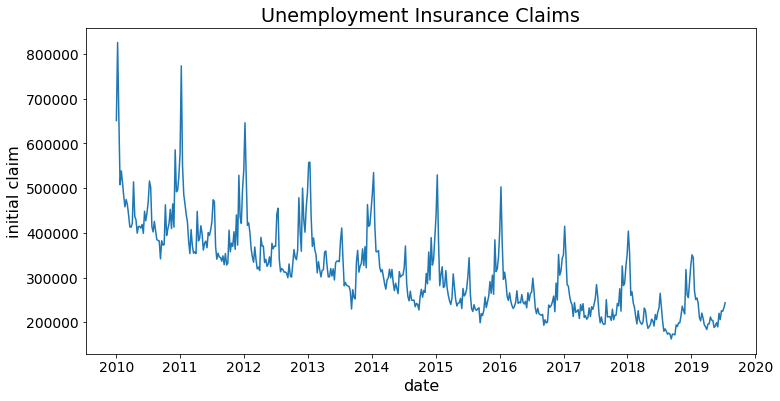

In [3]:
y = torch.tensor(unemployment['initial claim'].values, dtype=torch.float32)
sns.lineplot(x='date', y='initial claim', data=unemployment).set_title('Unemployment Insurance Claims');

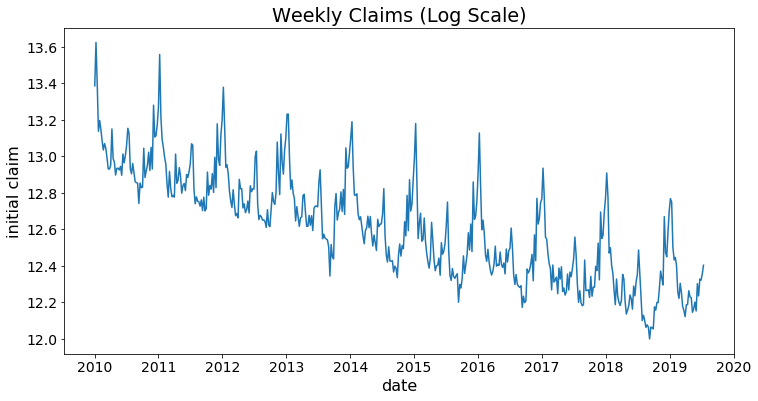

In [4]:
init_date = '2010-01-02'
time_range = pd.date_range(start=init_date, freq='7D', periods=len(y))
y_log = y.log()
fig, ax = plt.subplots()
ax.plot(time_range, y_log)
ax.set(title='Weekly Claims (Log Scale)', xlabel='date', ylabel='initial claim');

## Outline

 - Build a *regression model* to model the global trend and seasonality - estimate parameters using ML.
 - Build a *probabilistic model* for time series forecasting and infer latent parameters using:
   - SVI (Autoguides)
     - Delta Autoguide - MAP inference.
     - Diagonal Normal Autoguide. 
   - MCMC with a No-U-Turn Sampler (NUTS).

## Fitting a Regression Model

### A Global Trend Model

$$
\begin{align*}
ln(y_i) &\sim \mathcal{N}(\mu_i, \sigma)\\
\mu_i &= slope\ .\ t_i + intercept \\
\end{align*}
$$

For simplicity, let us assume that $\sigma = 1$ to begin with.

In [5]:
def model_global_trend(y):
    slope = pyro.param('slope', torch.tensor(0.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    for i in range(len(y)):
        log_y_hat = slope * i + intercept
        pyro.sample('y_{}'.format(i), dist.LogNormal(log_y_hat, 1.), obs=y[i])

 - `pyro.param` designate model parameters that we would like to optimize.
 - Observations are denoted by the `obs=` keyword argument to `pyro.sample`. This specifies the likelihood function.
 - Instead of log transforming the data, we use a *LogNormal* distribution.

## Vectorized Model Using `pyro.plate`
    
Tensor libraries like PyTorch have highly optimized linear algebra routines that can exploit data parallelism. Let us vectorize the *likelihood* computation to operate over all data in parallel.

In [6]:
def model_global_trend(y):
    slope = pyro.param('slope', torch.tensor(0.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    with pyro.plate('N', len(y)) as t:                        
        log_y_hat = slope * t.type(torch.float) + intercept
        pyro.sample('y', dist.LogNormal(log_y_hat, 1.), obs=y)

In [7]:
?pyro.plate

## Maximum Likelihood Estimate of the Parameters

**Test-Train Split**: Reserve the last 100 data-points for testing.

In [8]:
N = len(y)
N_test = 100
N_train = N - N_test
y_train = y[:N_train]

In [9]:
%%time

opt = optim.Adam({'lr': 0.08})
pyro.clear_param_store()
pyro.set_rng_seed(1)
empty_guide = lambda x: None
svi = SVI(model_global_trend, empty_guide, opt, loss=Trace_ELBO())

for i in range(1600):
    loss = svi.step(y_train)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 13.695740666221734
ELBO loss: 13.63005579656093
ELBO loss: 13.627845035725503
ELBO loss: 13.627821725816583
ELBO loss: 13.627820498979272
ELBO loss: 13.627818045304648
ELBO loss: 13.62781927214196
ELBO loss: 13.62781927214196
ELBO loss: 13.62781927214196
ELBO loss: 13.62781927214196
ELBO loss: 13.62781927214196
ELBO loss: 13.627818045304648
ELBO loss: 13.627818045304648
ELBO loss: 13.627818045304648
ELBO loss: 13.627818045304648
ELBO loss: 13.62781927214196
ELBO loss: 13.62781927214196
CPU times: user 1.1 s, sys: 24.4 ms, total: 1.13 s
Wall time: 1.12 s


 - Important arguments to `SVI` - *model*, *guide*, *loss*.
 - We pass an empty guide `lambda x: None` since the model does not have any latent parameters.
 - The loss function is given by `Trace_ELBO`. With an empty guide and only `pyro.param` statements in the model, this simply computes the NLL `- log(p(y|x))`. We minimize this using the Adam optimizer.

### Plotting the Regression Fit

In [10]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()

slope, intercept

(tensor(-0.0018), tensor(13.0523))

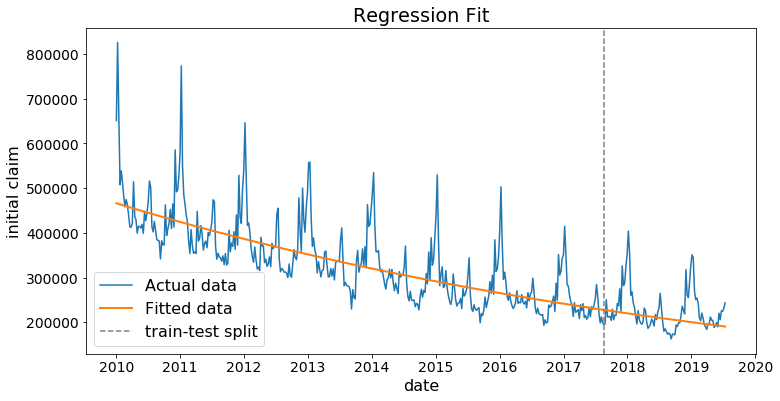

In [11]:
model_fit = (slope * torch.arange(len(y)).type(torch.float) + intercept).exp()

fig, ax = plt.subplots()
ax.plot(time_range, y, label='Actual data')
ax.plot(time_range, model_fit.detach(), linewidth=2, label='Fitted data')
ax.axvline(time_range[N_train], linestyle='--', color='gray', label='train-test split')
ax.set(title='Regression Fit', xlabel='date', ylabel='initial claim')
plt.legend();

## Modeling Seasonality

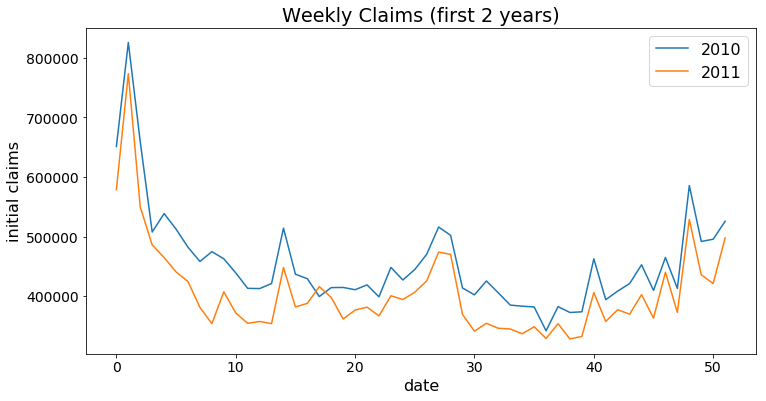

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(52), y[:52], label='2010');
ax.plot(np.arange(52), y[52:104], label='2011');
plt.legend()
ax.set(title='Weekly Claims (first 2 years)', xlabel='date', ylabel='initial claims');

## A Sesonal Global Trend (SGT) Model

In [13]:
def model_sgt(y):    
    slope = pyro.param('slope', torch.tensor(1.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    seasonality = pyro.param('seasonality', torch.zeros(52))
    seasonality = seasonality - seasonality.mean()
    N = len(y)
    with pyro.plate('N', N) as t:
        seasonality_factor = seasonality.repeat(math.ceil(N / 52))[:N]
        log_y_hat = slope * t.type(torch.float) + intercept + seasonality_factor
        pyro.sample('y', dist.LogNormal(log_y_hat, 1.), obs=y)

 - In addition to the *global trend*, this includes a cyclic seasonality term. Note that this is a *multiplier* term.
 - We will use `SVI` to fit this model in a similar fashion.

In [14]:
%%time

opt = optim.Adam({'lr': 0.08})
pyro.clear_param_store()
pyro.set_rng_seed(1)
empty_guide = lambda x: None
svi = SVI(model_sgt, empty_guide, opt, loss=Trace_ELBO())

for i in range(3000):
    loss = svi.step(y_train)
    if i % 500 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))        

ELBO loss: 26399.26381909548
ELBO loss: 13.683769187735553
ELBO loss: 13.631697304883794
ELBO loss: 13.61758131477701
ELBO loss: 13.615883371937814
ELBO loss: 13.615797493326005
ELBO loss: 13.615795039651381
CPU times: user 2.62 s, sys: 49.2 ms, total: 2.66 s
Wall time: 2.62 s


### Plotting the Regression Fit

In [15]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()

slope, intercept

(tensor(-0.0018), tensor(13.0455))

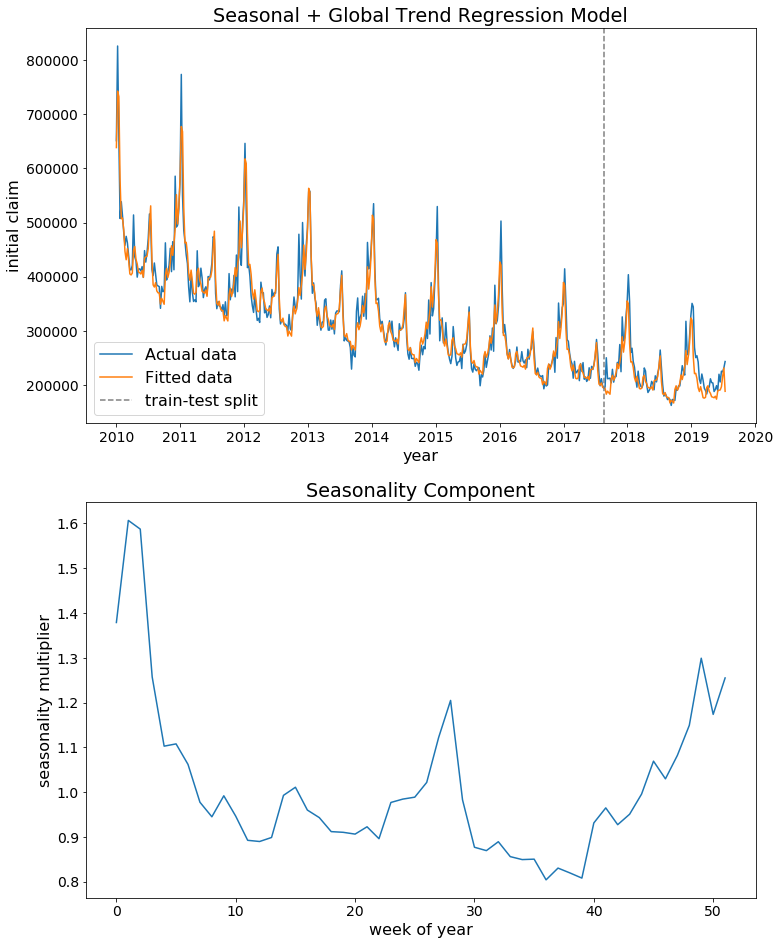

In [16]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()
seasonality = pyro.param('seasonality').detach()
seasonality = (seasonality - seasonality.mean())
seasonality_rep = seasonality.repeat(math.ceil(len(y) / 52))[:len(y)]
model_fit = (slope * torch.arange(len(y)).type(torch.float) + intercept + seasonality_rep).exp()

fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(time_range, y, label='Actual data')
ax[0].plot(time_range, model_fit.detach(), label='Fitted data')
ax[0].set(title='Seasonal + Global Trend Regression Model', 
          xlabel='year', 
          ylabel='initial claim')
ax[0].axvline(time_range[N_train], linestyle='--', color='gray', label='train-test split')
ax[0].legend();
ax[1].plot(range(52), seasonality.exp())
ax[1].set(title='Seasonality Component', 
          xlabel='week of year', 
          ylabel='seasonality multiplier');

## A Probabilistic Model for Forecasting

We build on our previous `SGT` model.

In [17]:
"""
N : Number of forecast steps from the current step.
x : Index for the last observed data from which to start forecasting.
y : Value for the last observed data.
"""
def prob_sgt(N, x, y):
    slope = pyro.sample('slope', dist.Normal(-0.18, 1.)) * 1e-2
    obs_sd = pyro.sample('obs_sd', dist.HalfNormal(1.)) * 0.1
    with pyro.plate('S', 52):
        seasonality = pyro.sample('seasonality', dist.Normal(0., 0.1))
        seasonality = seasonality - seasonality.mean()
    with pyro.plate('N', N) as t:
        seasonality_factor = seasonality.roll(-(x + 1) % 52).repeat(math.ceil(N / 52))[:N]
        y_intercept = y.log() - seasonality[x % 52]
        log_y_hat = slope * (t + 1).type(torch.float) + y_intercept + seasonality_factor
        return pyro.sample('y', dist.LogNormal(log_y_hat, obs_sd))

 - No `intercept` parameter, we instead take the current known value for `y` and forecast `N` steps ahead.
 - We need to account for which week we are in starting from the first week of Jan 2010 to apply the seasonality factor.
 - Priors for `slope`, `seasonality` and the observation noise `obs_sd`.
 - There is no `obs` argument. How are we going to train the model?

## Are the Priors Reasonable?

One way to check would be to generate samples from the model and check the overlap between distribution from the training set and the prior predictive distribution.

To generate samples from the prior, we will simply call the model multiple times and stack the predictions from the prior.

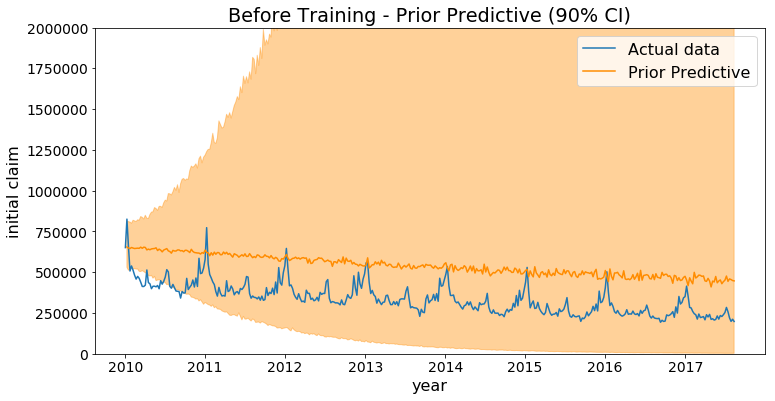

In [18]:
pyro.clear_param_store()

preds = []
for i in range(500):
    preds.append(prob_sgt(N_train-1, 0, y[0]).detach())
preds = torch.stack(preds)
quantiles = [0.1, 0.5, 0.9]
pred_p10, pred_p50, pred_p90 = [preds.kthvalue(int(q*500), dim=0)[0] for q in quantiles]

fig, ax = plt.subplots()
ax.plot(time_range[:N_train], y_train, label='Actual data')
ax.plot(time_range[1:N_train], pred_p50, label='Prior Predictive', color='darkorange')
ax.fill_between(time_range[1:N_train], pred_p10, pred_p90, alpha=0.4, 
                 color='darkorange')
ax.set(title='Before Training - Prior Predictive (90% CI)',
       xlabel='year', ylabel='initial claim', ylim=(0, 2e6))
plt.legend();

## Inference Using Stochastic Variational Inference

 - Provides a way to formulate the inference problem as an optimization problem.
 - Pyro provides state of the art support for VI. 
 - Optimize the parameters of a *guide* program to generate samples from the approx posterior.

## Autoguides

We will use autoguides from the [pyro.infer.autoguide](http://docs.pyro.ai/en/stable/infer.autoguide.html) module. 

### MAP Inference Using a Delta Autoguide

In [19]:
%%time

from pyro.contrib.autoguide import *

opt = optim.Adam({'lr': 0.05})
pyro.clear_param_store()
pyro.set_rng_seed(2)

model = poutine.condition(prob_sgt, {'y': y_train[1:]})
guide_delta = AutoDelta(model)
guide_delta(N_train-1, x=0, y=y_train[0])
svi = SVI(model, guide_delta, opt, loss=Trace_ELBO())

for i in range(5000):
    loss = svi.step(N_train-1, x=0, y=y_train[0])
    if i % 500 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 36.92019992317986
ELBO loss: 11.277748697217385
ELBO loss: 11.277750017505195
ELBO loss: 11.27774986415053
ELBO loss: 11.277952390849292
ELBO loss: 11.277790249891616
ELBO loss: 11.279893600311711
ELBO loss: 11.279929106409226
ELBO loss: 11.285316273644941
ELBO loss: 11.282411713096964
ELBO loss: 11.28483991856551
CPU times: user 11.8 s, sys: 102 ms, total: 11.9 s
Wall time: 11.9 s


Note the use of the `poutine.condition` handler to constrain the site `y` to our training set. The advantage of using `poutine.condition` is that we can use the same model for both training and forecasting!

### Examining the MAP Parameters

In [20]:
pyro.get_param_store().get_state()

{'params': {'auto_slope': tensor(-0.1762, requires_grad=True),
  'auto_obs_sd': tensor(-0.4678, requires_grad=True),
  'auto_seasonality': tensor([ 0.3359,  0.4530,  0.4416,  0.2195,  0.0945,  0.0989,  0.0587, -0.0203,
          -0.0525, -0.0063, -0.0512, -0.1070, -0.1099, -0.1003, -0.0053,  0.0119,
          -0.0374, -0.0543, -0.0864, -0.0880, -0.0922, -0.0751, -0.1031, -0.0206,
          -0.0133, -0.0091,  0.0221,  0.1115,  0.1792, -0.0148, -0.1235, -0.1317,
          -0.1101, -0.1465, -0.1533, -0.1521, -0.2049, -0.1745, -0.1869, -0.2005,
          -0.0660, -0.0324, -0.0699, -0.0463, -0.0026,  0.0649,  0.0293,  0.0763,
           0.1332,  0.2492,  0.1532,  0.2166], requires_grad=True)},
 'constraints': {'auto_slope': Real(),
  'auto_obs_sd': GreaterThan(lower_bound=0.0),
  'auto_seasonality': Real()}}

## Generating Forecasts

### Replaying from a Trained Guide

&nbsp;
&nbsp;
&nbsp;

<center>
<img src="static/guide_program.png" width="600" align="center">
</center>

In [21]:
@torch.no_grad()
def get_predictive_samples(model, *args, 
                           guide,
                           num_samples=500, 
                           quantiles=[0.1, 0.5, 0.9]):    
    preds = defaultdict(list)
    for i in range(num_samples):
        guide_trace = poutine.trace(guide).get_trace(*args)
        replay_model = poutine.replay(model, guide_trace)
        model_trace = poutine.trace(replay_model).get_trace(*args)
        preds['slope_sd'].append(model_trace.nodes['slope']['value'].detach())
        preds['slope'].append(model_trace.nodes['slope']['value'].detach())
        preds['obs_sd'].append(model_trace.nodes['obs_sd']['value'].detach())
        preds['y'].append(model_trace.nodes['y']['value'].detach())
    return {k: torch.stack(v) for k, v in preds.items()}

 - Model remains the same for both inference and prediction. 
 - To generate forecasts we can simply run the guide to sample latent values from the approximate posterior distribution, and replay these values in the model.

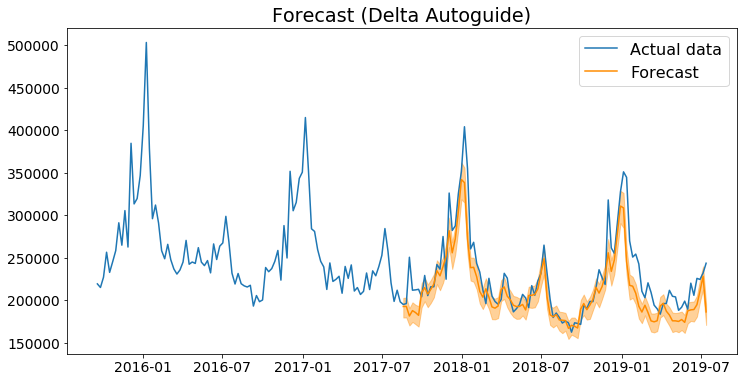

In [22]:
forecast_delta = get_predictive_samples(prob_sgt, N_test, N_train-1, y[N_train-1], 
                                        guide=guide_delta)
p10, p50, p90 = [forecast_delta['y'].kthvalue(int(q * (N_train-1)), dim=0)[0] for q in quantiles]
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], p50, label='Forecast',
         color='darkorange')
plt.fill_between(time_range[398:len(y)], p10, p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (Delta Autoguide)')
plt.legend();

### Variational Inference Using a Normal Autoguide

 - The model and training procedure remains the same as earlier.
 - The Diagonal Normal Autoguide samples from a Normal distribution with diagonal covariance to generate samples from the approximate posterior distribution.

In [23]:
%%time

opt = optim.ClippedAdam({'lr': 0.8 * 1e-3})
pyro.clear_param_store()
pyro.set_rng_seed(1)

model = poutine.condition(prob_sgt, {'y': y_train[1:]})
guide_diagnormal = AutoDiagonalNormal(model)
pyro.param('auto_scale', torch.ones(54).fill_(1e-2), constraint=constraints.positive)

svi = SVI(model, guide_diagnormal, opt, loss=Trace_ELBO())

for i in range(10000):
    loss = svi.step(N=N_train-1, x=0, y=y_train[0])
    if i % 1000 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 14.939578771712867
ELBO loss: 11.734191343862207
ELBO loss: 11.704581206393001
ELBO loss: 11.676283765827591
ELBO loss: 11.674187613117635
ELBO loss: 11.675871746998336
ELBO loss: 11.69711156983172
ELBO loss: 11.675094893829307
ELBO loss: 11.694186113887097
ELBO loss: 11.678180580462643
ELBO loss: 11.671968777050925
CPU times: user 26.5 s, sys: 167 ms, total: 26.7 s
Wall time: 26.7 s


### Plotting the Model's Forecast

In [24]:
guide_diagnormal.quantiles([0.1, 0.5, 0.9])

{'slope': [tensor(-0.1798, grad_fn=<ViewBackward>),
  tensor(-0.1779, grad_fn=<ViewBackward>),
  tensor(-0.1760, grad_fn=<ViewBackward>)],
 'obs_sd': [tensor(0.6430, grad_fn=<AddBackward0>),
  tensor(0.6725, grad_fn=<AddBackward0>),
  tensor(0.7033, grad_fn=<AddBackward0>)],
 'seasonality': [tensor([ 0.3318,  0.4163,  0.4074,  0.1835,  0.0542,  0.0622,  0.0256, -0.0554,
          -0.0820, -0.0421, -0.0873, -0.1409, -0.1411, -0.1319, -0.0423, -0.0241,
          -0.0679, -0.0887, -0.1230, -0.1194, -0.1215, -0.1088, -0.1373, -0.0594,
          -0.0470, -0.0423, -0.0107,  0.0796,  0.1445, -0.0462, -0.1558, -0.1632,
          -0.1473, -0.1792, -0.1810, -0.1856, -0.2392, -0.2100, -0.2177, -0.2339,
          -0.0994, -0.0711, -0.0970, -0.0840, -0.0391,  0.0221, -0.0059,  0.0419,
           0.1034,  0.2129,  0.1195,  0.1865], grad_fn=<ViewBackward>),
  tensor([ 0.3362,  0.4458,  0.4377,  0.2126,  0.0842,  0.0925,  0.0557, -0.0259,
          -0.0523, -0.0135, -0.0584, -0.1121, -0.1112, -0.1022,

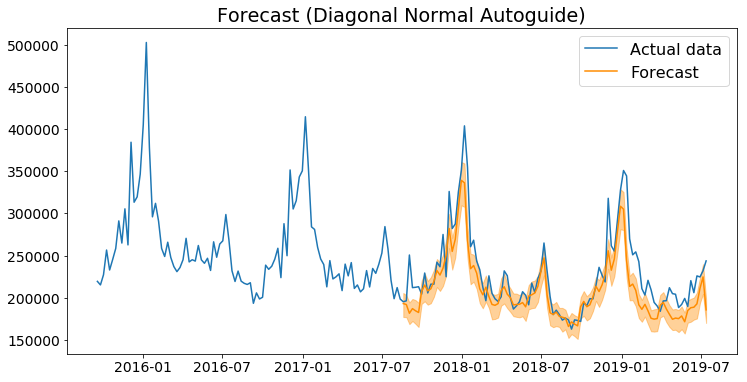

In [25]:
forecast_diagnormal = get_predictive_samples(prob_sgt, N_test, N_train-1, y[N_train-1], 
                                             guide=guide_diagnormal)
p10, p50, p90 = [forecast_diagnormal['y'].kthvalue(int(q * (N_train-1)), dim=0)[0]
                 for q in quantiles]
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], p50, label='Forecast',
         color='darkorange')
plt.fill_between(time_range[N_train:N_train+N_test], p10, p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (Diagonal Normal Autoguide)')
plt.legend();

## Inference Using MCMC

 - Pyro provides support for Hamiltonian Monte Carlo which is well suited to sample from high-dimensional continuous spaces.
 - In particular, we use the No-U-Turn algorithm for running HMC which adaptively sets many critical parameters for HMC.

In [26]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc.util import predictive
from pyro.ops.stats import hpdi

from torch.distributions.transforms import AffineTransform

In [27]:
model = poutine.condition(prob_sgt, {'y': y_train[1:]})
nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=500, num_chains=4)
mcmc.run(N_train-1, x=0, y=y_train[0])

### Model Summary

In [28]:
mcmc.summary()



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          slope     -0.18      0.00     -0.18     -0.18     -0.17   4333.87      1.00
         obs_sd      0.67      0.03      0.67      0.62      0.71   1541.13      1.00
 seasonality[0]      0.34      0.01      0.34      0.31      0.36    102.18      1.04
 seasonality[1]      0.45      0.03      0.45      0.40      0.49    353.92      1.01
 seasonality[2]      0.44      0.03      0.44      0.40      0.48    414.67      1.01
 seasonality[3]      0.22      0.03      0.22      0.17      0.26    301.08      1.02
 seasonality[4]      0.09      0.03      0.09      0.05      0.14    359.58      1.01
 seasonality[5]      0.09      0.03      0.09      0.06      0.14    377.37      1.01
 seasonality[6]      0.06      0.03      0.06      0.01      0.10    367.45      1.01
 seasonality[7]     -0.02      0.03     -0.02     -0.07      0.02    362.63      1.02
 seasonality[8]     -0.05      0.03     -0.05     -0

### Plotting Model Forecast

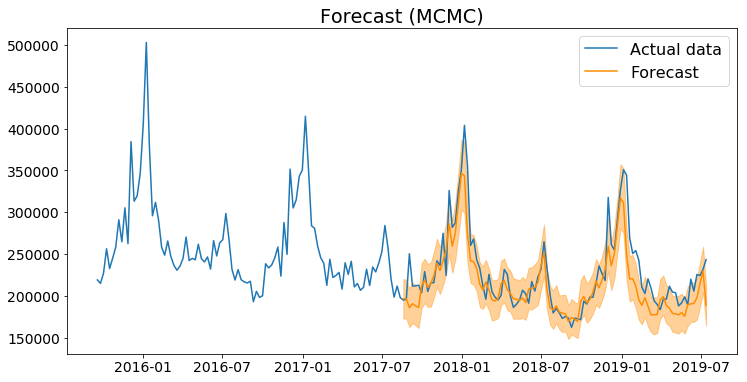

In [29]:
from pyro.util import ignore_experimental_warning

with ignore_experimental_warning():
    forecast_mcmc = predictive(prob_sgt, mcmc.get_samples(), N_test, N_train-1, y[N_train-1])

p10, p90 = hpdi(forecast_mcmc['y'], prob=0.9)
p50 = forecast_mcmc['y'].median(dim=0)[0]
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], p50, label='Forecast',
         color='darkorange')
plt.fill_between(time_range[N_train:N_train+N_test], p10, p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (MCMC)')
plt.legend();

### Posterior Distribution of Slope for MCMC and SVI

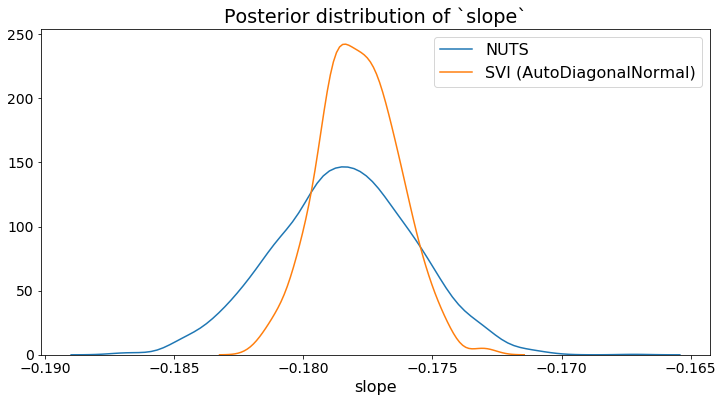

In [30]:
samples = mcmc.get_samples()
fig, ax = plt.subplots()
sns.kdeplot(samples['slope'].cpu().numpy(),
            ax=ax, label='NUTS')
sns.kdeplot(forecast_diagnormal['slope'].cpu().numpy(), 
            ax=ax, label='SVI (AutoDiagonalNormal)')
ax.set(title='Posterior distribution of `slope`', 
       xlabel='slope')
ax.legend();

### Variational Inference Using a Multivariate Normal Autoguide

In [31]:
%%time

opt = optim.ClippedAdam({'lr': 0.5 * 1e-3})
pyro.clear_param_store()
pyro.set_rng_seed(1)

model = poutine.condition(prob_sgt, {'y': y_train[1:]})
guide_mvn = AutoMultivariateNormal(model)
pyro.param('auto_scale_tril', torch.diag_embed(torch.full((54,), 1e-2)), 
           constraint=constraints.lower_cholesky)

svi = SVI(model, guide_mvn, opt, loss=Trace_ELBO())

for i in range(12000):
    loss = svi.step(N=N_train-1, x=0, y=y_train[0])
    if i % 1000 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 14.939578388326208
ELBO loss: 11.768799503918869
ELBO loss: 11.713003909692693
ELBO loss: 11.74804127568276
ELBO loss: 11.69806735464676
ELBO loss: 11.686150272213036
ELBO loss: 11.734777652887843
ELBO loss: 11.697045560008917
ELBO loss: 11.670354566532163
ELBO loss: 11.701796592105573
ELBO loss: 11.758209825909917
ELBO loss: 11.71254045699709
ELBO loss: 11.697509620207638
CPU times: user 35.3 s, sys: 200 ms, total: 35.5 s
Wall time: 35.5 s


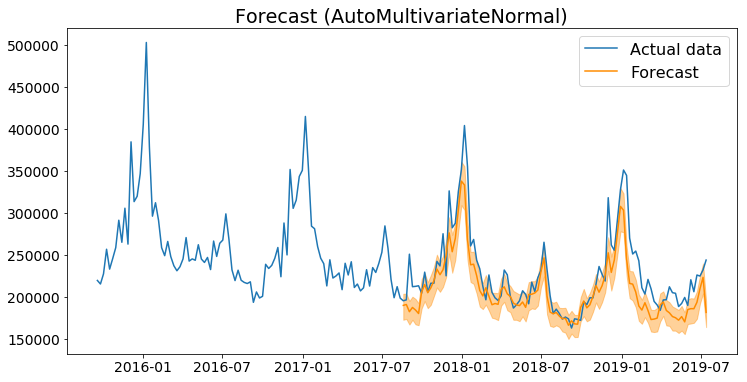

In [32]:
forecast_mvn = get_predictive_samples(prob_sgt, N_test, N_train-1, y[N_train-1], 
                                      guide=guide_mvn)
p10, p50, p90 = [forecast_mvn['y'].kthvalue(int(q * (N_train-1)), dim=0)[0]
                 for q in quantiles]
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], p50, label='Forecast',
         color='darkorange')
plt.fill_between(time_range[N_train:N_train+N_test], p10, p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (AutoMultivariateNormal)')
plt.legend();

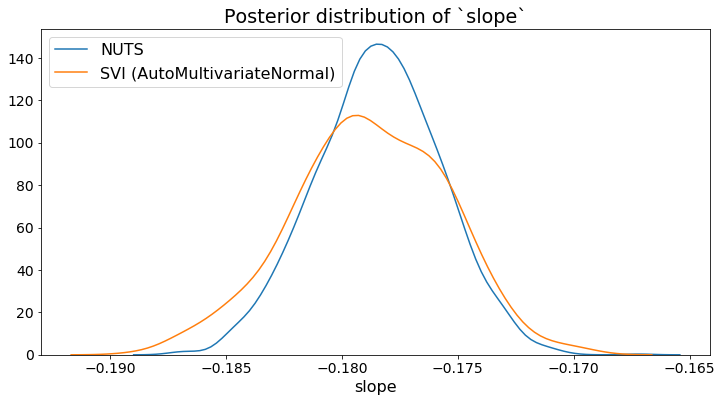

In [33]:
samples = mcmc.get_samples()
fig, ax = plt.subplots()
sns.kdeplot(samples['slope'].cpu().numpy(),
            ax=ax, label='NUTS')
sns.kdeplot(forecast_mvn['slope'].cpu().numpy(), 
            ax=ax, label='SVI (AutoMultivariateNormal)')
ax.set(title='Posterior distribution of `slope`', 
       xlabel='slope')
ax.legend();

## Next..

**Custom guide programs for scalable and flexible inference.**

To recap:
 - Modeling in Pyro is for the most part distinct from *inference*.
 - Pyro an array of black-box inference algorithms to use out of the box:
   - ML estimation using null guides. 
   - SVI with autoguides - AutoDelta, AutoDiagNormal, AutoMultivariateNormal, flow-based guides, etc.
   - MCMC using NUTS sampler.